# Keyframe extraction using sound
We want to extract the start and stop times for our abilities using sound. So first we must translate all the videos in our dataset to `.wav` or audio files that can then be analyzed using `librosa`.

In [1]:
import os

import ffmpeg
import threading

os.makedirs("Data/Audios", exist_ok=True)
def run_ffmpeg_with_timeout(command_func, timeout):
    result = {}
    def target():
        try:
            command_func()
            result["success"] = True
        except Exception as e:
            result["error"] = e

    thread = threading.Thread(target=target)
    thread.start()
    thread.join(timeout)

    if thread.is_alive():
        raise TimeoutError("FFmpeg process timed out.")

    if "error" in result:
        raise result["error"]

def webm_to_wav(input_file, output_file, timeout=1):
    try:
        run_ffmpeg_with_timeout(
            lambda: (
                ffmpeg
                .input(input_file)
                .output(output_file, format='wav')
                .overwrite_output()
                .run(capture_stdout=True, capture_stderr=True)
            ),
            timeout
        )
        print(f"Converted {input_file} to {output_file}")
    except TimeoutError:
        print(f"Timeout: Conversion of {input_file} took longer than {timeout} seconds.")
    except ffmpeg.Error as e:
        print(f"Error occurred:\n{e.stderr.decode()}")


In [11]:
path = "Data/Videos/"

for dir, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(".webm"):
            input_file = os.path.join(dir, filename)
            output = input_file.replace(".webm", ".wav").replace("Videos", "Audios")
            os.makedirs(os.path.dirname(output), exist_ok=True)
            webm_to_wav(input_file, output)

Converted Data/Videos/Rakan/E1.webm to Data/Audios/Rakan/E1.wav
Converted Data/Videos/Rakan/W1.webm to Data/Audios/Rakan/W1.wav
Converted Data/Videos/Rakan/Q1.webm to Data/Audios/Rakan/Q1.wav
Converted Data/Videos/Rakan/P1.webm to Data/Audios/Rakan/P1.wav
Converted Data/Videos/Rakan/R1.webm to Data/Audios/Rakan/R1.wav
Converted Data/Videos/Smolder/E1.webm to Data/Audios/Smolder/E1.wav
Converted Data/Videos/Smolder/W1.webm to Data/Audios/Smolder/W1.wav
Converted Data/Videos/Smolder/Q1.webm to Data/Audios/Smolder/Q1.wav
Converted Data/Videos/Smolder/P1.webm to Data/Audios/Smolder/P1.wav
Converted Data/Videos/Smolder/R1.webm to Data/Audios/Smolder/R1.wav
Converted Data/Videos/Diana/E1.webm to Data/Audios/Diana/E1.wav
Converted Data/Videos/Diana/W1.webm to Data/Audios/Diana/W1.wav
Converted Data/Videos/Diana/Q1.webm to Data/Audios/Diana/Q1.wav
Converted Data/Videos/Diana/P1.webm to Data/Audios/Diana/P1.wav
Converted Data/Videos/Diana/R1.webm to Data/Audios/Diana/R1.wav
Converted Data/Video

In [29]:
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

def get_sound_start_end_with_noise_gate(audio_file, threshold_ratio=0.1, padding=0.1, plot=True):
    """
    Returns start and end times of a sound using an adaptive noise gate.
    Creates a plot to show the amplitude cut-off.
    
    :param audio_file: Path to the audio file.
    :param threshold_ratio: Proportion of the max amplitude to consider as noise (e.g., 0.1 = 10%).
    :param padding: Time (in seconds) to extend start and end times for safety.
    :param plot: Whether to plot the waveform and noise gate.
    """
    y, sr = librosa.load(audio_file)

    # Compute amplitude envelope and threshold
    envelope = np.abs(y)
    noise_threshold = threshold_ratio * np.max(envelope)
    sound_indices = np.where(envelope > noise_threshold)[0]

    if len(sound_indices) == 0:
        # No significant sound above thresholds
        return None, None

    # Calculate start and end times
    start_idx = sound_indices[0]
    end_idx = sound_indices[-1]
    start_time = max(0, librosa.samples_to_time(start_idx, sr=sr) - padding)
    end_time = librosa.samples_to_time(end_idx, sr=sr) + padding

    if plot:
        sns.set_theme(style="whitegrid", palette="muted")
        time = librosa.samples_to_time(np.arange(len(y)), sr=sr)

        plt.figure(figsize=(8, 4))
        plt.plot(time, envelope, color=sns.color_palette("muted")[0], linewidth=0.8)  # Blue
        plt.axhspan(0, noise_threshold, color=sns.color_palette("muted")[3], alpha=0.3)  # Orange
        plt.axvspan(start_time, end_time, color=sns.color_palette("muted")[4], alpha=0.3)  # Green
        plt.tight_layout()
        plt.ylim(0, 0.2)
        plt.yticks(np.arange(0, 0.2, 0.05))
        plt.tight_layout()
        plt.tick_params(colors='white')
        plt.savefig('nilah_w1.png', format='png', dpi=600, transparent=True)
        
    return start_time, end_time

(np.float64(2.9686621315192743), np.float64(6.618956916099773))

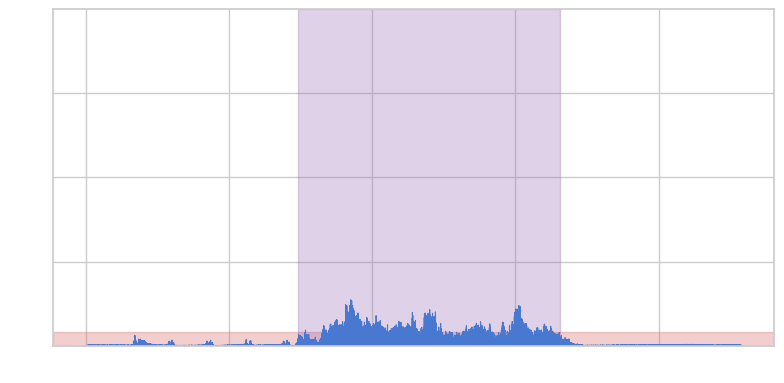

In [30]:
get_sound_start_end_with_noise_gate(os.path.join("Data/Audios/Nilah", "W1.wav"), threshold_ratio=0.3)

In [17]:
AUDIO_PATH = "Data/Audios/"
threshold_ratio = 0.05

def get_sound_start_ends(audio_path, threshold_ratio):
    thresholds = {}
    for dir_name, _, sound_files in os.walk(audio_path):
        for sound_file in sound_files:
            if not sound_file.endswith(".wav"):
                continue
            filename = os.path.join(dir_name, sound_file)
            start, end = get_sound_start_end_with_noise_gate(filename, threshold_ratio=threshold_ratio, plot=False)
            if start is not None and end is not None:
                thresholds[filename.removeprefix('Data/Audios/').removesuffix('.wav')] = np.array([start, end])
    return thresholds

In [36]:
threshold_ratios = np.arange(0.1, 0.2, step=0.02)
audio_start_stops_by_threshold = []
for threshold_ratio in threshold_ratios:
    audio_start_stops_by_threshold.append(get_sound_start_ends(AUDIO_PATH, threshold_ratio))

In [37]:
average_audio_start_stops = {}
for key in audio_start_stops_by_threshold[0].keys():
    values = np.array([audio_start_stop[key] for audio_start_stop in audio_start_stops_by_threshold])
    average_audio_start_stops[key] = np.mean(values, axis=0)

average_audio_start_stops

{'Rakan/R1': array([0.23476644, 4.45237188]),
 'Rakan/W1': array([0.12978685, 2.51315193]),
 'Rakan/P1': array([0.92637642, 4.38488889]),
 'Rakan/E1': array([0.17811338, 2.42786395]),
 'Rakan/Q1': array([0.13219955, 5.02321995]),
 'Smolder/R1': array([0.32642177, 4.11482086]),
 'Smolder/W1': array([0.13646259, 2.63000454]),
 'Smolder/P1': array([0.06110658, 4.55088435]),
 'Smolder/E1': array([0.0215873 , 5.47212698]),
 'Smolder/Q1': array([ 0.32163265, 11.83810431]),
 'Diana/R1': array([0.82670295, 3.51645351]),
 'Diana/W1': array([0.22169615, 5.45849433]),
 'Diana/P1': array([0.40945125, 3.28562358]),
 'Diana/E1': array([0.32746485, 1.57171882]),
 'Diana/Q1': array([0.31852154, 1.744     ]),
 'Vayne/R1': array([0.30731066, 6.79331519]),
 'Vayne/W1': array([0.23668027, 3.45352381]),
 'Vayne/P1': array([0.        , 8.38773696]),
 'Vayne/E1': array([0.53534694, 2.5315102 ]),
 'Vayne/Q1': array([0.17854875, 1.5398458 ]),
 'Nilah/R1': array([2.0578322 , 3.82490703]),
 'Nilah/W1': array([0.

In [38]:
import statistics
import numpy as np

def analyze_global_error(audio_start_stops_by_threshold):
    keys = audio_start_stops_by_threshold[0].keys()    
    key_errors = {key: [] for key in keys}
    
    for key in keys:
        values = [d[key] for d in audio_start_stops_by_threshold]
        for i in range(len(values)):
            for j in range(i + 1, len(values)):
                key_errors[key].append(abs(np.subtract(values[i], values[j])).sum())
    
    key_errors = {key: statistics.mean(errors) for key, errors in key_errors.items()}
    overall_mae = statistics.mean(key_errors.values())
    
    return overall_mae, key_errors


In [43]:
overall_mae, mae_by_video = analyze_global_error(audio_start_stops_by_threshold)

# Extract those audios for which we are more or less sure - have little background noise for example
low_error_audio_start_stop = [key for key, error in mae_by_video.items() if error < 0.02]

In [46]:
low_error_audio_start_stop

(['Smolder/E1',
  'Talon/E1',
  'Akali/Q1',
  "Bel'Veth/R1",
  "Bel'Veth/P1",
  'Rell/Q1',
  'Gwen/E1',
  'Graves/P1',
  'Graves/E1',
  'Qiyana/R1',
  'Ahri/W1',
  'Kayle/R1',
  'Rammus/E1',
  'Thresh/E1',
  'Thresh/Q1',
  'Warwick/W1',
  'Warwick/P1',
  'Nasus/P1',
  'Twisted Fate/E1',
  'Sylas/E1',
  'Ivern/W1',
  'Orianna/E1',
  'Orianna/Q1',
  'Leona/E1',
  'Shaco/E1',
  'Shaco/Q1',
  'Ryze/E1',
  'Ryze/Q1',
  'Kled/E1',
  'Jhin/Q1',
  'Singed/W1',
  'Aatrox/W1',
  'Samira/Q1',
  'Pantheon/W1',
  'Kennen/E1',
  'Jarvan IV/R1',
  'Seraphine/R1',
  'Seraphine/P1',
  'Cassiopeia/P1',
  'Yorick/P1',
  'Sivir/Q1',
  'Zeri/R1',
  'Zeri/Q1',
  'Tryndamere/W1',
  'Miss Fortune/E1',
  'Miss Fortune/Q1',
  'Amumu/E1',
  'Amumu/Q1',
  'Janna/P1',
  'Janna/E1',
  'Teemo/P1',
  'Sett/E1',
  'Olaf/P1',
  'Olaf/Q1',
  'Alistar/W1',
  'Zyra/W1',
  'Galio/E1',
  'Rumble/W1',
  'Anivia/W1',
  'Shen/Q1',
  'Irelia/E1',
  'Nidalee/W2',
  'Twitch/Q1',
  'Lulu/E1',
  'Nunu & Willump/P1',
  'Lee Sin/W1',

In [45]:
len(low_error_audio_start_stop), len(average_audio_start_stops)

(74, 846)

In [42]:
import json

gt_audio_start_stops = {k: v.tolist() for k, v in average_audio_start_stops.items() if k in low_error_audio_start_stop}

with open(os.path.join("Data/GT", 'timing.json'), 'w') as f:
    json.dump(gt_audio_start_stops, f)  
